<a href="https://colab.research.google.com/github/sga-noud/TM10007_ML/blob/master/TM10007_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and load dataset


In [1]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn

# Pre-processing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, \
    RepeatedStratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Classifiers
from sklearn.neighbors import KNeighborsClassifier  # K-NN
from sklearn.ensemble import RandomForestClassifier  # RF
from sklearn.svm import SVC  # SVM

# Grid search
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Figures
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

In [2]:
# Scoring metric
scoring = 'roc_auc'

# Cross-validation
cv = 5

# Run cross_val_score() functions for all 3 classifiers?
# It is not needed for plotting the ROC curve, only for validation
# If True, running may take up to 10 minutes
run_cv_score = True

# Random state for stratified train-test split
# Should be an integer, or None
random_state = 1

Load dataset and split in train/test

In [3]:
# Clone repo containing dataset
!git clone https://github.com/jveenland/TM10007_ML.git
df = pd.read_csv('TM10007_ML/worcliver/Liver_radiomicFeatures.csv', index_col=0)

# Count NaN's
print(f"Number of NA values: {df.isnull().sum().sum()}")

# Split labels and data, make labels binary
Y_labels = df.pop('label').replace({'benign': 0, 'malignant': 1})
X_target = df

# Stratified split of data into train:test with ratio 80:20
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=random_state)
for (train, test) in splitter.split(X_target, Y_labels):
    x_train = X_target.iloc[train]
    y_train = Y_labels.iloc[train]
    x_test = X_target.iloc[test]
    y_test = Y_labels.iloc[test]

display(x_train.head())

Cloning into 'TM10007_ML'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 67.99 MiB | 5.38 MiB/s, done.
Number of NA values: 0


,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,PREDICT_original_sf_cvar_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Liver-157_0,0.798396,0.055069,27.397307,4.370313,4.864699,2.261143,0.953693,0.027252,0.028409,0.011055,...,0.0,0.154678,1.322361,0.786144,0.0,0,0.528354,602.090294,0.208940,12.633451
Liver-054_0,0.615551,0.164996,33.279375,9.871035,10.947477,3.599170,0.913388,0.067697,0.094500,0.056300,...,0.0,0.137650,1.747400,2.266524,0.0,0,0.471458,1144.738981,0.130663,13.655659
Liver-064_0,0.818469,0.021134,26.187268,3.442943,9.978877,1.739349,0.967959,0.005983,0.017838,0.004587,...,0.0,0.126912,3.177497,10.282532,0.0,0,0.523373,114.636661,0.000000,9.832352
Liver-107_0,0.863305,0.041397,20.226254,2.207196,5.627608,2.472796,0.971243,0.024797,0.014910,0.009646,...,0.0,0.157725,1.443712,1.204595,0.0,0,0.540882,559.081045,0.197772,12.426019
Liver-154_0,0.894020,0.051396,16.377001,1.517166,6.403027,0.667186,0.979402,0.016410,0.010815,0.007485,...,0.0,0.136149,2.037447,3.677631,0.0,0,0.501538,191.863915,0.102217,11.039403


## Pre-processing
Remove some features with zero or minimal variance as explained [here](https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/).

In [4]:
constant_filter = VarianceThreshold(threshold=0)

# Fit on train set
constant_filter.fit(x_train)
print(f"Original x_train: {len(x_train.columns)}")
print(f"Constant features: {len(x_train.columns) - len(x_train.columns[constant_filter.get_support()])}")
print(f"Non-constant features: {len(x_train.columns[constant_filter.get_support()])}")

# Transform train and test set
x_train = constant_filter.transform(x_train)
x_test = constant_filter.transform(x_test)
print(f"New x_train shape: {x_train.shape}")

Original x_train: 493
Constant features: 17
Non-constant features: 476
New x_train shape: (148, 476)


Scale values using statistics that are robust to outliers with `RobustScaler`.

In [5]:
# Robust scaling, fit on train set
transformer = RobustScaler(quantile_range=(0.05, 0.95)).fit(x_train)

# Transform train and test set
x_train_scaled = transformer.transform(x_train)
x_test_scaled = transformer.transform(x_test)

# Turn results back into a DataFrame
x_train = pd.DataFrame(x_train_scaled)
x_test = pd.DataFrame(x_test_scaled)

## Feature selection
Calculate optimal number of features using `RFECV`.

In [6]:
# Calculate optimal number of features
rfecv = RFECV(
    SVC(kernel='linear'), cv=cv, step=5, scoring=scoring,
    min_features_to_select=1  # minimum number of features to consider
)

# Fit on train set
rfecv.fit(x_train, y_train)

print(rfecv)
print(f"Classes: {rfecv.classes_}")
print(f"Features seen during fit: {rfecv.n_features_in_}")
print(f"Optimal number of features: {rfecv.n_features_}")

RFECV(cv=5, estimator=SVC(kernel='linear'), scoring='roc_auc', step=5)
Classes: [0 1]
Features seen during fit: 476
Optimal number of features: 46


Filter dataset using the `RFECV` mask, so that only the important features remain

In [7]:
# Get feature mask
mask_ = rfecv.support_

# Transform train and test set
x_train = x_train[x_train.columns[mask_]]
x_test = x_test[x_test.columns[mask_]]

display(x_train.head())
print(f"New train shape: {x_train.shape}. New test shape: {x_test.shape}")

,4,5,8,18,19,25,43,53,54,57,...,337,343,344,348,384,389,456,459,462,467
0,-18.417455,-1.239633,5.418345,0.202201,-17.419976,16.747389,9.721451,-1.350276,0.093877,-1.315865,...,-4.875709,5.789766,7.329251,16.160619,28.756069,-11.767988,7.174015,6.002755,7.174015,51.698278
1,19.432685,2.385255,78.796578,-13.334626,18.496498,5.239035,5.482193,-0.696147,2.119898,-0.661736,...,-5.210820,45.710164,12.222209,77.654339,42.030840,-2.816842,6.986384,4.840245,6.986384,23.772492
2,13.405563,-2.653240,-6.318484,24.564325,-74.514019,15.014269,1.932573,1.903724,-13.319989,1.938134,...,4.397523,2.462832,-2.243361,2.962108,-31.508675,1.938794,-1.844886,-2.004941,-1.844886,-6.547217
3,-13.670250,-0.666236,-9.568934,-7.136093,30.214031,42.011189,-1.917934,2.123374,69.830796,2.157784,...,28.880658,66.555457,4.876441,101.751576,-0.095455,35.522507,5.457170,5.385519,5.457170,48.745940
4,-8.845198,-5.557867,-14.115330,15.205962,5.008271,17.548710,15.281153,1.971714,49.267321,2.006125,...,73.105506,102.410580,-2.477148,145.201389,-48.893826,172.291520,2.575434,3.126883,2.575434,17.930457


New train shape: (148, 46). New test shape: (38, 46)


Reduce dimensionality with PCA, if after RFECV more features remain than samples in the original dataset. Otherwise, just continue.

In [8]:
# Hyperparameters
max_features = df.index.size

# If too many features remain after RFECV, further reduce dimensions with PCA
if rfecv.n_features_ > max_features:
    # PCA
    pca = PCA(n_components=max_features)
    pca = pca.fit(x_train)

    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    print(f"x_test shape: {x_train.shape}")

    # Plot
    dim_list = range(0,9,2)
    fig = plt.figure()
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(f'After PCA reduction from {rfecv.n_features_} to {max_features} dimensions')

    for i, val in enumerate(dim_list):
        ax = fig.add_subplot(2, 3, i+1)
        plt.xlabel(f'Dimension {val}')
        plt.ylabel(f'Dimension {val+1}')
        ax.scatter(x_train[:,val], x_train[:,val+1], marker='o', c=y_train,
                s=25, edgecolor='k', cmap=plt.cm.Paired)


## k-Nearest Neighbor Classifier (KNN)
Use a grid search to find the optimal k-value.

In [9]:
# Train model on train set
model_KNN = KNeighborsClassifier()
model_KNN.fit(x_train, y_train)
  
# Print prediction results
predictions_KNN = model_KNN.predict(x_train)
print(classification_report(y_train, predictions_KNN))

param_grid_KNN = { 
    'n_neighbors' : [10, 50, 60, 70, 80],
    'weights' : ['uniform', 'distance'],
    'metric' : ['minkowski', 'euclidean', 'manhattan'],
    'algorithm' : ['brute', 'auto', 'ball_tree', 'kd_tree']
}

grid_KNN = GridSearchCV(
    KNeighborsClassifier(), param_grid_KNN, refit=True, verbose=1, cv=cv, scoring=scoring
)
  
# Fit model for grid search
grid_KNN.fit(x_train, y_train)

# Best parameters after tuning
print(f"Best parameters: {grid_KNN.best_params_}")
print(f"Best estimator: {grid_KNN.best_estimator_}")

if run_cv_score:
    grid_predictions_KNN = grid_KNN.predict(x_train) 

    # Print classification report
    print(classification_report(y_train, grid_predictions_KNN)) 

    scores_KNN = cross_val_score(grid_KNN, x_train, y_train, cv=cv, scoring=scoring)
    print(f"All scores: {[round(score, 3) for score in scores_KNN]}")

              precision    recall  f1-score   support

           0       0.68      0.86      0.76        73
           1       0.82      0.61      0.70        75

    accuracy                           0.74       148
   macro avg       0.75      0.74      0.73       148
weighted avg       0.75      0.74      0.73       148

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 60, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=60,
                     weights='distance')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        75

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148

Fitting 5 folds for each of 120 candidates, t

##Random Forest

In [10]:
# Train model on train set
model_RF = RandomForestClassifier()
model_RF.fit(x_train, y_train)
  
# Print prediction results
predictions_RF = model_RF.predict(x_train)
print(classification_report(y_train, predictions_RF))

param_grid_RF = {
    'n_estimators': [10, 30, 50, 70],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, 6, 7, 8],
    'max_leaf_nodes': [5, 6, 7, 8],
}

grid_RF = GridSearchCV(
    RandomForestClassifier(), param_grid_RF, refit=True, verbose=1, scoring=scoring, cv=cv
)

# Fit model for grid search
grid_RF.fit(x_train, y_train)

# Best parameters after tuning
print(f"Best parameters: {grid_RF.best_params_}")
print(f"Best estimator: {grid_RF.best_estimator_}")

if run_cv_score:
    grid_predictions_RF = grid_RF.predict(x_train)

    # Print classification report
    print(classification_report(y_train, grid_predictions_RF)) 

    scores_RF = cross_val_score(grid_RF, x_train, y_train, scoring=scoring, cv=cv)
    print(f"All scores: {[round(score, 3) for score in scores_RF]}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        75

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 70}
Best estimator: RandomForestClassifier(max_depth=8, max_leaf_nodes=6, n_estimators=70)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       0.99      0.95      0.97        75

    accuracy                           0.97       148
   macro avg       0.97      0.97      0.97       148
weighted avg       0.97      0.97      0.97       148

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 ca

## SVM

In [11]:
# Train model on train set
model = SVC()
model.fit(x_train, y_train)
  
# Print prediction results
predictions = model.predict(x_train)
print(classification_report(y_train, predictions))

param_grid_SVM = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100, 400, 500, 600, 700],
    'degree' : [1, 2],  # in poly kernel
    'coef0' : [0.0, 0.0001, 0.001, 0.01]
}

grid_SVM = GridSearchCV(
    SVC(), param_grid_SVM, refit=True, verbose=1, scoring=scoring, cv=cv
)

# Fit model for grid search
grid_SVM.fit(x_train, y_train)

# Best parameters after tuning
print(f"Best parameters: {grid_SVM.best_params_}")
print(f"Best estimator: {grid_SVM.best_estimator_}")

if run_cv_score:
    grid_predictions = grid_SVM.predict(x_train)

    # Print classification report
    print(classification_report(y_train, grid_predictions)) 

    scores_SVM = cross_val_score(grid_SVM, x_train, y_train, scoring=scoring, cv=cv)
    print(f"All scores: {[round(score, 3) for score in scores_SVM]}")

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        73
           1       0.87      0.72      0.79        75

    accuracy                           0.80       148
   macro avg       0.81      0.81      0.80       148
weighted avg       0.81      0.80      0.80       148

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best parameters: {'C': 500, 'coef0': 0.0, 'degree': 1, 'kernel': 'poly'}
Best estimator: SVC(C=500, degree=1, kernel='poly')
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.99      0.99      0.99        75

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Fitting 5 folds for each of 168 candidates, totalling 840 fits
Fitting 5 folds for each of 168 

## Results
ROC curves on test set 

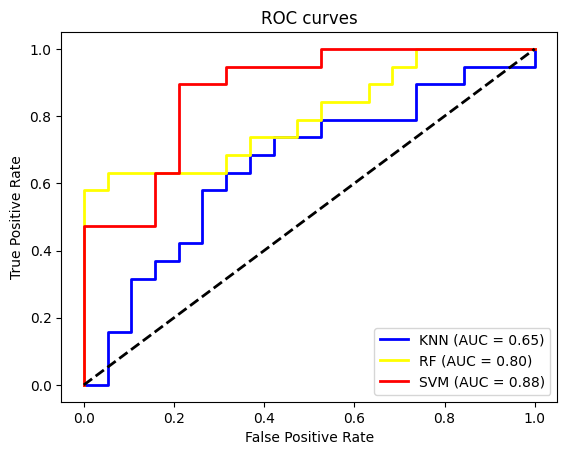

In [12]:
# Predict scores for classifiers
y_pred_KNN = grid_KNN.predict_proba(x_test)[::,1]
y_pred_RF = grid_RF.predict_proba(x_test)[::,1]
y_score_SVM = grid_SVM.decision_function(x_test)

# Compute ROC curve and ROC area for each classifier
fpr_KNN, tpr_KNN, _ = roc_curve(y_test, y_pred_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

fpr_SVM, tpr_SVM, _ = roc_curve(y_test,  y_score_SVM)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

# Plot ROC curves for all classifiers
plt.figure()
lw = 2
plt.plot(fpr_KNN, tpr_KNN, color='blue',
         lw=lw, label='KNN (AUC = %0.2f)' % roc_auc_KNN)
plt.plot(fpr_RF, tpr_RF, color='yellow',
         lw=lw, label='RF (AUC = %0.2f)' % roc_auc_RF)
plt.plot(fpr_SVM, tpr_SVM, color='red',
         lw=lw, label='SVM (AUC = %0.2f)' % roc_auc_SVM)

# Add labels and legend
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

Learning curves

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py", line 237, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_base.py", line 810, in kneighbors
    raise ValueError(
ValueError: Expected

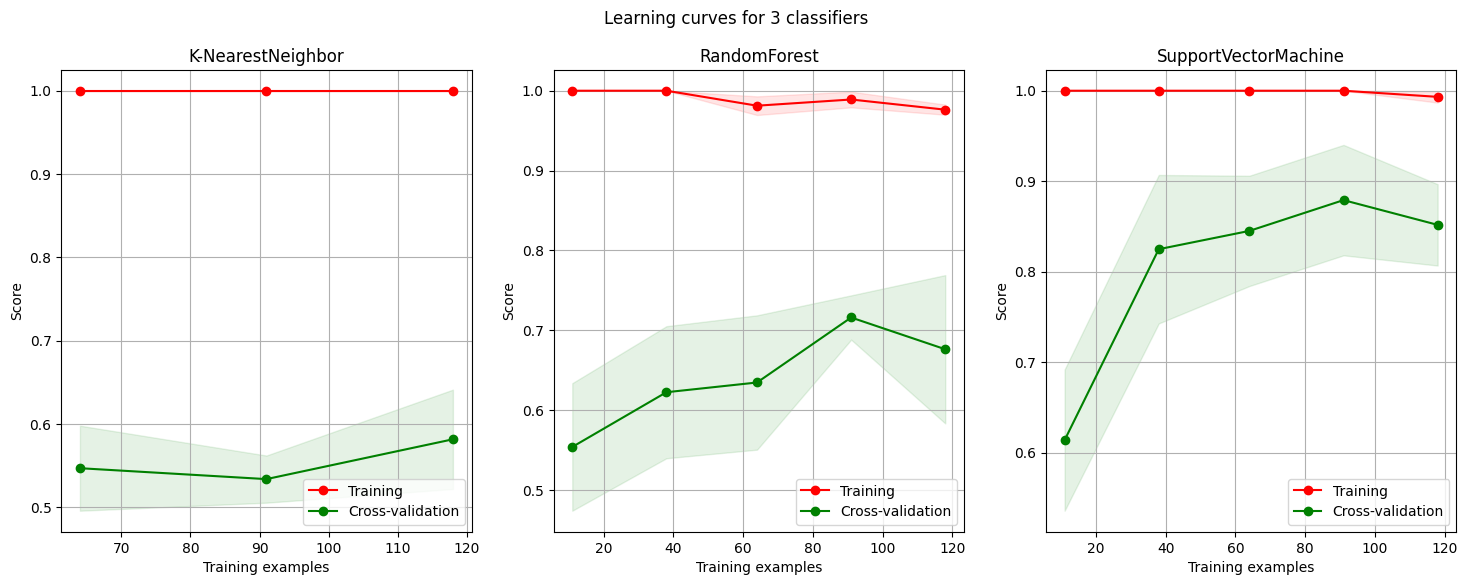

In [13]:
# List classifiers with their optimal hyperparameters
clfs = [
    {'name': 'K-NearestNeighbor', 'clf': grid_KNN.best_estimator_},
    {'name': 'RandomForest', 'clf': grid_RF.best_estimator_},
    {'name': 'SupportVectorMachine', 'clf': grid_SVM.best_estimator_}
]

fig = plt.figure(figsize=(18,6))
fig.suptitle('Learning curves for 3 classifiers')

for (i, clf) in enumerate(clfs):
    # Calculate learning curve
    train_sizes, train_scores, test_scores = \
        learning_curve(clf['clf'], x_train, y_train, cv=cv, n_jobs=None)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    ax = fig.add_subplot(1, 3, i+1)
    plt.title(clf['name'])
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation")
    plt.legend(loc="lower right")